## Practical project 1 - 02 - Model search - baseline selection

Explainable Automated Machine Learning course, LTAT.02.023
University of Tartu, Institute of Computer Science

Each team will work on a machine learning problem from end-to-end.

#### Project's general description:
<details>
  <summary>Click here for more information!</summary>

  Each team will work on a machine learning problem from end-to-end.

  **Step 1:** Choose a dataset. Build and train a baseline for comparison. To construct the baseline you do the following:
  * Try a set of possible machine learning algorithms (**13 algorithms**) using their **default hyperparameters** and choose the one with the highest performance for comparison.


  **Step 2:** Based on the problem at hand, you study:
  * the **potential pipeline structure**,
  * **algorithms**
  * or **feature transformers** at each step,
  * **hyper-parameters ranges**.
  
  Use hyperOpt with the potential search space to beat the baseline.


  **Step 3:** Monitor the performance of you the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.


  **Step 4:** Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

</details>

#### Dataset used:
<details>
  <summary>Click here for more information!</summary>

  Dataset is taken from Kaggle competition - Drinking Water Quality Prediction. The goal of the competition is to create a model that predicts the water quality in Estonian water stations based on the government's open data of the previous measurements.

  [Reference](https://www.kaggle.com/competitions/copy-of-drinking-water-quality)
</details>

</details>

#### References:
<details>
  <summary>Click here for more information!</summary>

  [MLJ for Data Scientists in Two Hours](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/telco/)
</details>

### Activate the current project. Check the packages available

In [ ]:
using Pkg

Pkg.activate(".")
Pkg.status()


### Get packages to use

In [67]:
using DataFrames
using CSV
using MLJ
using Random
using Plots

using MLJScikitLearnInterface
using MLJDecisionTreeInterface
using MLJXGBoostInterface

### Get adjusted datasets

In [3]:
df_train = CSV.read(joinpath(@__DIR__, "data/adjusted/train_adjusted.csv"), delim=';', DataFrame)
display(first(df_train, 3))
df_test = CSV.read(joinpath(@__DIR__, "data/adjusted/test_adjusted.csv"), delim=';', DataFrame)
display(first(df_test, 3))

,ammonium,coli-like-bacteria,colony-count-at-22-c,color-pt/co-scale,electrical-conductivity
,Float64,Float64,Float64,Float64,Float64
1,0.05,0.0,0.0,0.0,448.0
2,0.09,0.0,15.0,4.0,978.0
3,0.06,0.0,1.0,3.5,446.0


,ammonium,coli-like-bacteria,colony-count-at-22-c,color-pt/co-scale,electrical-conductivity
,Float64,Float64,Float64,Float64,Float64
1,0.08,0.0,12.0,11.7,716.0
2,0.08,0.0,35.3333,7.7,996.0
3,0.065,0.0,58.6667,4.0,734.0


### Adjust the scientific data types

#### View the initiall set scientific data types

In [4]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


#### Adjust the scientific data types adn change target column's levels

* change scientific data type for taget column 'compliance': Count -> OrderedFactor
* adjust appropriate levels: negative one (1) should be first

In [5]:
coerce!(df_train, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_train, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_train.compliance, [1, 0])
levels(df_train.compliance)

2-element Vector{Int64}:
 1
 0

#### View the adjusted scientific data types

In [6]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


### Split the data "horizontally" into input and target parts

In [7]:
y, X = unpack(df_train, ==(:compliance); rng=123)
first(X, 3) |> pretty

┌────────────┬────────────────────┬──────────────────────┬───────────────────┬─────────────────────────┬──────────────────┬────────────┬────────────┬──────────────────────┬───────────────────────┬───────────────┬────────────┐
│ ammonium   │ coli-like-bacteria │ colony-count-at-22-c │ color-pt/co-scale │ electrical-conductivity │ escherichia-coli │ iron       │ manganese  │ odour-dilution-level │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64            │ Float64              │ Float64           │ Float64                 │ Float64          │ Float64    │ Float64    │ Float64              │ Float64               │ Float64       │ Float64    │
│ Continuous │ Continuous         │ Continuous           │ Continuous        │ Continuous              │ Continuous       │ Continuous │ Continuous │ Continuous           │ Continuous            │ Continuous    │ Continuous │
├────────────┼────────────────────┼──────────────────────┼───────────────────┼──────────────────

### Search for models

In [8]:
show(stdout, "text/plain", models(matching(X, y)))

51-element 

Vector{

NamedTuple{

(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:


(name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 

(name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 

(name = BaggingClassifier, package_name = ScikitLearn, ... )
 

(name = BayesianLDA, package_name = MultivariateStats, ... )
 

(name = BayesianLDA, package_name = ScikitLearn, ... )
 

(name = BayesianQDA, package_name = ScikitLearn, ... )
 

(name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 

(name = ConstantClassifier, package_name = MLJModels, ... )
 

(name = DSADDetector, package_name = OutlierDetectionNetworks, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 

(name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 

(name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = DummyClassifier, package_name = ScikitLearn, ... )
 

(name = ESADDetector, package_name = OutlierDetectionNetworks, ... )
 

(name = EvoTreeClassifier, package_name = EvoTrees, ... )
 

(name = ExtraTreesClassifier, package_name = ScikitLearn, ... )
 

(name = GaussianNBClassifier, package_name = NaiveBayes, ... )
 

(name = GaussianNBClassifier, package_name = ScikitLearn, ... )
 

(name = GaussianProcessClassifier, package_name = ScikitLearn, ... )
 

(name = GradientBoostingClassifier, package_name = ScikitLearn, ... )
 

(name = KNNClassifier, package_name = NearestNeighborModels, ... )
 (name = KNeighborsClassifier, package_name = ScikitLearn, ... )
 (name = KernelPerceptron, package_name = BetaML, ... )
 (name = LDA, package_name = MultivariateStats, ... )
 

(name = LGBMClassifier, package_name = LightGBM, ... )
 

(name = LinearBinaryClassifier, package_name = GLM, ... )
 

(name = LinearPerceptron, package_name = BetaML, ... )
 

(name = LinearSVC, package_name = LIBSVM, ... )
 

(name = LogisticCVClassifier, package_name = ScikitLearn, ... )
 (name = LogisticClassifier, package_name = MLJLinearModels, ... )
 

(name = LogisticClassifier, package_name = ScikitLearn, ... )
 (name = MultinomialClassifier, package_name = MLJLinearModels, ... )
 

(name = NeuralNetworkClassifier, package_name = BetaML, ... )
 

(name = NeuralNetworkClassifier, package_name = MLJFlux, ... )
 

(name = NuSVC, package_name = LIBSVM, ... )
 

(name = PassiveAggressiveClassifier, package_name = ScikitLearn, ... )
 

(name = Pegasos, package_name = BetaML, ... )
 (name = PerceptronClassifier, package_name = ScikitLearn, ... )
 

(name = ProbabilisticSGDClassifier, package_name = ScikitLearn, ... )
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )
 

(name = RandomForestClassifier, package_name = ScikitLearn, ... )
 

(name = RidgeCVClassifier, package_name = ScikitLearn, ... )
 

(name = RidgeClassifier, package_name = ScikitLearn, ... )
 

(name = SGDClassifier, package_name = ScikitLearn, ... )
 

(name = SVC, package_name = LIBSVM, ... )
 

(name = SVMClassifier, package_name = ScikitLearn, ... )
 

(name = SVMLinearClassifier, package_name = ScikitLearn, ... )
 (name = SVMNuClassifier, package_name = ScikitLearn, ... )
 (name = SubspaceLDA, package_name = MultivariateStats, ... )
 

(name = XGBoostClassifier, package_name = XGBoost, ... )

### The models selection made:

1. AdaBoostClassifier, package_name = ScikitLearn
2. BaggingClassifier, package_name = ScikitLearn
3. BayesianLDA, package_name = ScikitLearn
4. DecisionTreeClassifier, package_name = DecisionTree
5. GaussianNBClassifier, package_name = ScikitLearn
6. KNeighborsClassifier, package_name = ScikitLearn
7. LogisticClassifier, package_name = ScikitLearn
8. GaussianProcessClassifier, package_name = ScikitLearn
9. ProbabilisticSGDClassifier, package_name = ScikitLearn
10. RandomForestClassifier, package_name = ScikitLearn
11. BayesianQDA, package_name = ScikitLearn
12. DummyClassifier, package_name = ScikitLearn
13. XGBoostClassifier, package_name = XGBoost

### Looking for **baseline**

#### Dataset partition on train/validation

In [9]:
train, validation = partition(1:length(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  534, 535, 536, 537, 538, 539, 540, 541, 542, 543], [544, 545, 546, 547, 548, 549, 550, 551, 552, 553  …  767, 768, 769, 770, 771, 772, 773, 774, 775, 776])

#### Define 'get_measurements' function

In [205]:
function get_measurements(model_name, ŷ, y)
    #_brier_loss = round(brier_loss(ŷ, y) |> mean, digits=3)
    #_auc = round(auc(ŷ, y), digits=3)
    _accuracy = round(accuracy(mode.(ŷ), y), digits=3)
    return DataFrame(model=[model_name], measure=["accuracy"], measurement=[_accuracy])
end

get_measurements (generic function with 3 methods)

#### Define 'print_measurements' function

In [206]:
function get_measurements_str(df)
    return string("Measurement:\n",
    #"  brier loss: ", df[df.measure .== "brier_loss", :], "\n",
    #"  auc:        ", df[df.measure .== "auc", :], "\n",
    "  accuracy:   ", df[df.measure .== "accuracy", :], "\n" ) 
end

get_measurements_str (generic function with 1 method)

#### Define 'plot_roccurve' function

In [207]:
function plot_roccurve(ŷ, y)
    roc_curve = roc(ŷ, y)
    plt = scatter(roc_curve, legend=false)
    plot!(plt, xlab="false positive rate", ylab="true positive rate")
    plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)
end

plot_roccurve (generic function with 2 methods)

#### Define 'get_machine' function

In [208]:
function get_machine(model, X, y)
   _model = model
   show(stdout, "text/plain", _model)
   return machine(_model, X, y)
end

get_machine (generic function with 1 method)

#### Define 'fit_predict' function

In [209]:
function fit_predict(machine, y, train, validation)
    fit!(machine, rows=train)
    ŷ = predict(machine, rows=validation)
    return ŷ
end

fit_predict (generic function with 1 method)

#### 1. AdaBoostClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
AdaBoostClassifier(
  base_estimator = nothing, 
  n_estimators = 50, 
  learning_rate = 1.0, 
  algorithm = "SAMME.R", 
  random_state = nothing)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


┌ Info: Training machine(AdaBoostClassifier(base_estimator = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


1×3 DataFrame
 Row │ model               measure   measurement 
     │ String              String    Float64     
─────┼───────────────────────────────────────────
   1 │ AdaBoostClassifier  accuracy        0.867
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     29      │      8      │
├─────────────┼─────────────┼─────────────┤
│      0      │     23      │     173     │
└─────────────┴─────────────┴─────────────┘


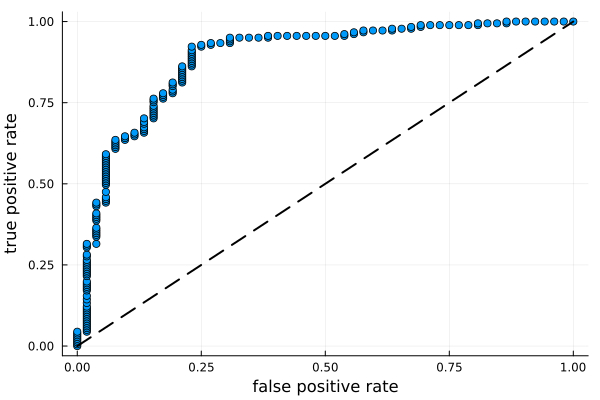

In [210]:
AdaBoostClassifier = @load AdaBoostClassifier pkg=ScikitLearn
_machine = get_machine(AdaBoostClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_1 = get_measurements("AdaBoostClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_1)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 2. BaggingClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BaggingClassifier(
  base_estimator = nothing, 
  n_estimators = 10, 
  max_samples = 1.0, 
  max_features = 1.0, 
  bootstrap = true, 
  bootstrap_features = false, 
  oob_score = false, 
  warm_start = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(BaggingClassifier(base_estimator = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


1×3 DataFrame
 Row │ model              measure   measurement 
     │ String             String    Float64     
─────┼──────────────────────────────────────────
   1 │ BaggingClassifier  accuracy        0.863
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     32      │     12      │
├─────────────┼─────────────┼─────────────┤
│      0      │     20      │     169     │
└─────────────┴─────────────┴─────────────┘


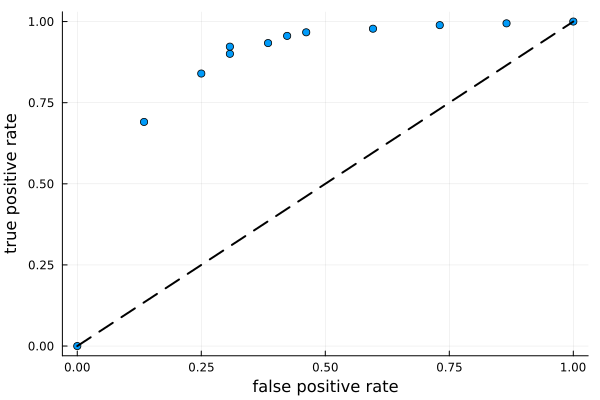

In [211]:
BaggingClassifier = @load BaggingClassifier pkg=ScikitLearn
_machine = get_machine(BaggingClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_2 = get_measurements("BaggingClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_2)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 3. BayesianLDA, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BayesianLDA(
  solver = "svd", 
  shrinkage = nothing, 
  priors = nothing, 
  n_components = nothing, 
  store_covariance = false, 
  tol = 0.0001)1×3 DataFrame
 Row │ model        measure   measurement 
     │ String       String    Float64     
─────┼────────────────────────────────────
   1 │ BayesianLDA  accuracy        0.824
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     16      │      5      │
├─────────────┼─────────────┼─────────────┤
│      0      │     36      │     176     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(BayesianLDA(solver = svd, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


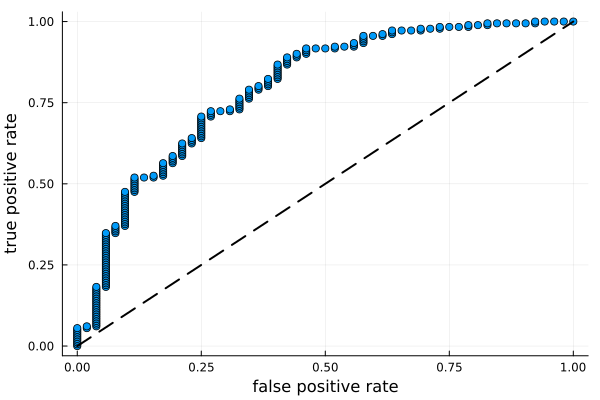

In [212]:
BayesianLDA = @load BayesianLDA pkg=ScikitLearn
_machine = get_machine(BayesianLDA(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_3 = get_measurements("BayesianLDA", ŷ, y[validation])
show(stdout, "text/plain", measurements_3)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 4. DecisionTreeClassifier, package_name=DecisionTree: parameters + evaluation

import MLJDecisionTreeInterface ✔
DecisionTreeClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())1×3 DataFrame
 Row │ model                   measure   measurement 
     │ String                  String    Float64     
─────┼───────────────────────────────────────────────
   1 │ DecisionTreeClassifier  accuracy        0.863
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     29      │      9      │
├─────────────┼─────────────┼─────────────┤
│      0      │     23      │     172     │
└─────────────┴─────────────┴─────────────┘


┌ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


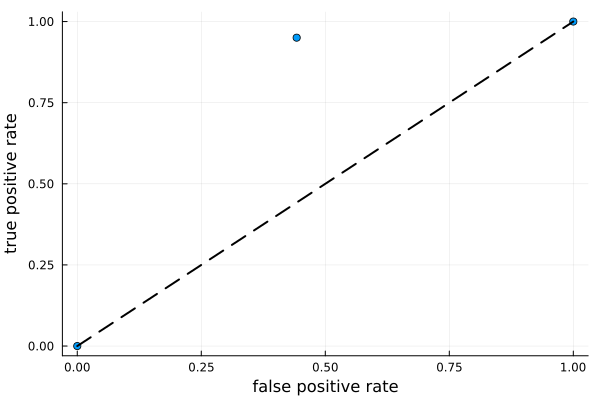

In [213]:
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree
_machine = get_machine(DecisionTreeClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_4 = get_measurements("DecisionTreeClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_4)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 5. GaussianNBClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
GaussianNBClassifier(
  priors = nothing, 
  var_smoothing = 1.0e-9)1×3 DataFrame
 Row │ model                 measure   measurement 
     │ String                String    Float64     
─────┼─────────────────────────────────────────────
   1 │ GaussianNBClassifier  accuracy        0.845
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     25      │      9      │
├─────────────┼─────────────┼─────────────┤
│      0      │     27      │     172     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(GaussianNBClassifier(priors = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


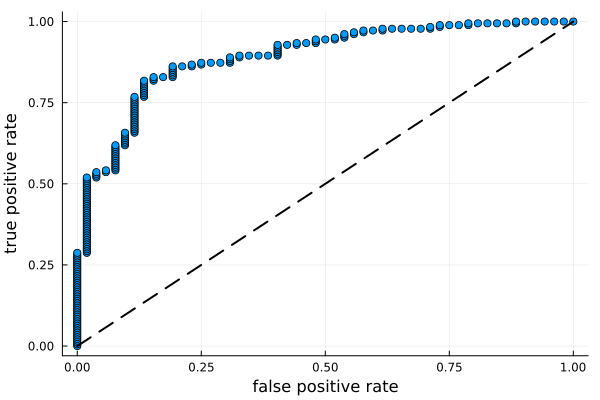

In [214]:
GaussianNBClassifier = @load GaussianNBClassifier pkg=ScikitLearn
_machine = get_machine(GaussianNBClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_5 = get_measurements("GaussianNBClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_5)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 6. KNeighborsClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
KNeighborsClassifier(
  n_neighbors = 5, 
  weights = "uniform", 
  algorithm = "auto", 
  leaf_size = 30, 
  p = 2, 
  metric = "minkowski", 
  metric_params = nothing, 
  n_jobs = nothing)1×3 DataFrame
 Row │ model                 measure   measurement 
     │ String                String    Float64     
─────┼─────────────────────────────────────────────
   1 │ KNeighborsClassifier  accuracy        0.824
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     17      │      6      │
├─────────────┼─────────────┼─────────────┤
│      0      │     35      │     175     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(KNeighborsClassifier(n_neighbors = 5, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


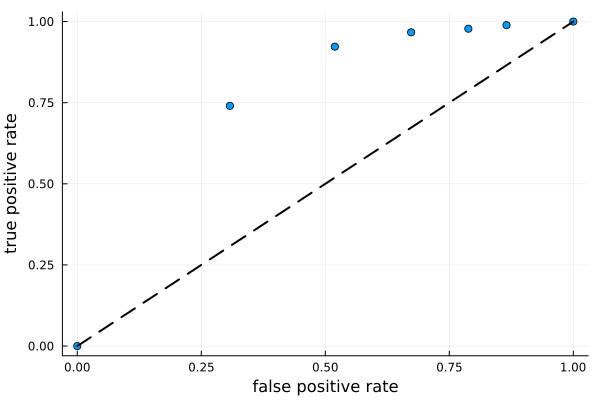

In [215]:
KNeighborsClassifier = @load KNeighborsClassifier pkg=ScikitLearn
_machine = get_machine(KNeighborsClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_6 = get_measurements("KNeighborsClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_6)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 7. LogisticClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
LogisticClassifier(
  penalty = "l2", 
  dual = false, 
  tol = 0.0001, 
  C = 1.0, 
  fit_intercept = true, 
  intercept_scaling = 1.0, 
  class_weight = nothing, 
  random_state = nothing, 
  solver = "lbfgs", 
  max_iter = 100, 
  multi_class = "auto", 
  verbose = 0, 
  warm_start = false, 
  n_jobs = nothing, 
  l1_ratio = nothing)1×3 DataFrame
 Row │ model               measure   measurement 
     │ String              String    Float64     
─────┼───────────────────────────────────────────
   1 │ LogisticClassifier  accuracy        0.845
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     21      │      5      │
├─────────────┼─────────────┼─────────────┤
│      0      │     31      │     176     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


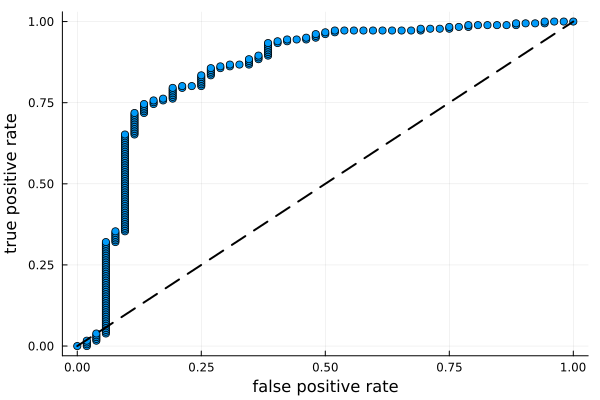

In [216]:
LogisticClassifier = @load LogisticClassifier pkg=ScikitLearn
_machine = get_machine(LogisticClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_7 = get_measurements("LogisticClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_7)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 8. GaussianProcessClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
GaussianProcessClassifier(
  kernel = nothing, 
  optimizer = "fmin_l_bfgs_b", 
  n_restarts_optimizer = 0, 
  copy_X_train = true, 
  random_state = nothing, 
  max_iter_predict = 100, 
  warm_start = false, 
  multi_class = "one_vs_rest")

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(GaussianProcessClassifier(kernel = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


1×3 DataFrame
 Row │ model                      measure   measurement 
     │ String                     String    Float64     
─────┼──────────────────────────────────────────────────
   1 │ GaussianProcessClassifier  accuracy        0.309
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     50      │     159     │
├─────────────┼─────────────┼─────────────┤
│      0      │      2      │     22      │
└─────────────┴─────────────┴─────────────┘


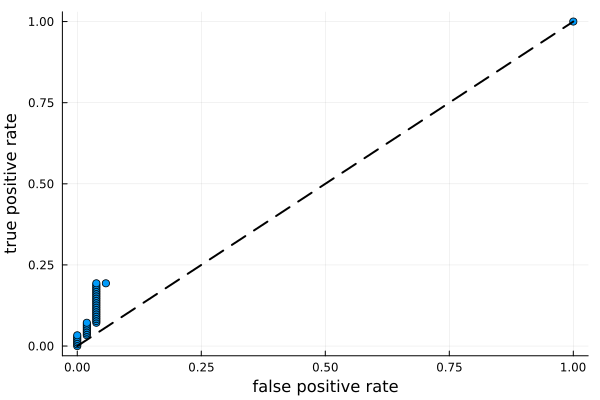

In [217]:
GaussianProcessClassifier = @load GaussianProcessClassifier pkg=ScikitLearn
_machine = get_machine(GaussianProcessClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_8 = get_measurements("GaussianProcessClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_8)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 9. ProbabilisticSGDClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
ProbabilisticSGDClassifier(
  loss = "log", 
  penalty = "l2", 
  alpha = 0.0001, 
  l1_ratio = 0.15, 
  fit_intercept = true, 
  max_iter = 1000, 
  tol = 0.001, 
  shuffle = true, 
  verbose = 0, 
  epsilon = 0.1, 
  n_jobs = nothing, 
  random_state = nothing, 
  learning_rate = "optimal", 
  eta0 = 0.0, 
  power_t = 0.5, 
  early_stopping = false, 
  validation_fraction = 0.1, 
  n_iter_no_change = 5, 
  class_weight = nothing, 
  warm_start = false, 
  average = false)1×3 DataFrame
 Row │ model                       measure   measurement 
     │ String                      String    Float64     
─────┼───────────────────────────────────────────────────
   1 │ ProbabilisticSGDClassifier  accuracy         0.79
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     23  

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(ProbabilisticSGDClassifier(loss = log, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


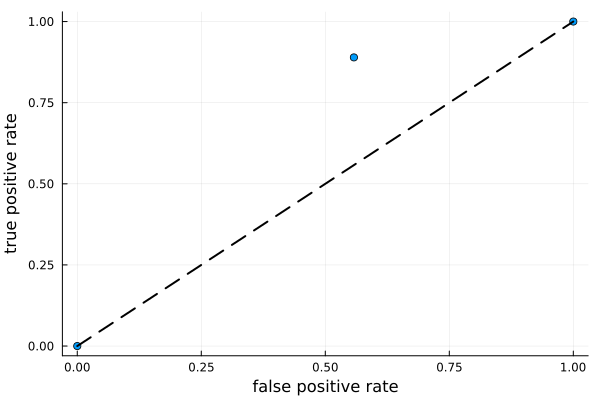

In [218]:
ProbabilisticSGDClassifier = @load ProbabilisticSGDClassifier pkg=ScikitLearn
_machine = get_machine(ProbabilisticSGDClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_9 = get_measurements("ProbabilisticSGDClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_9)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 10. RandomForestClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
RandomForestClassifier(
  n_estimators = 100, 
  criterion = "gini", 
  max_depth = nothing, 
  min_samples_split = 2, 
  min_samples_leaf = 1, 
  min_weight_fraction_leaf = 0.0, 
  max_features = "auto", 
  max_leaf_nodes = nothing, 
  min_impurity_decrease = 0.0, 
  bootstrap = true, 
  oob_score = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0, 
  warm_start = false, 
  class_weight = nothing, 
  ccp_alpha = 0.0, 
  max_samples = nothing)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


1×3 DataFrame
 Row │ model                   measure   measurement 
     │ String                  String    Float64     
─────┼───────────────────────────────────────────────
   1 │ RandomForestClassifier  accuracy        0.884
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     31      │      6      │
├─────────────┼─────────────┼─────────────┤
│      0      │     21      │     175     │
└─────────────┴─────────────┴─────────────┘


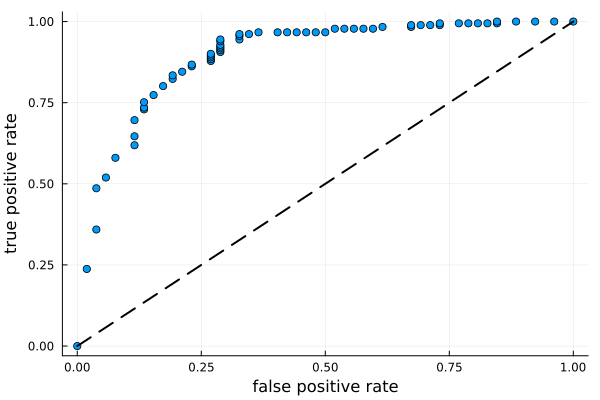

In [219]:
RandomForestClassifier = @load RandomForestClassifier pkg=ScikitLearn
_machine = get_machine(RandomForestClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_10 = get_measurements("RandomForestClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_10)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 11. BayesianQDA, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BayesianQDA(
  priors = nothing, 
  reg_param = 0.0, 
  store_covariance = false, 
  tol = 0.0001)1×3 DataFrame
 Row │ model        measure   measurement 
     │ String       String    Float64     
─────┼────────────────────────────────────
   1 │ BayesianQDA  accuracy        0.845
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     26      │     10      │
├─────────────┼─────────────┼─────────────┤
│      0      │     26      │     171     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(BayesianQDA(priors = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


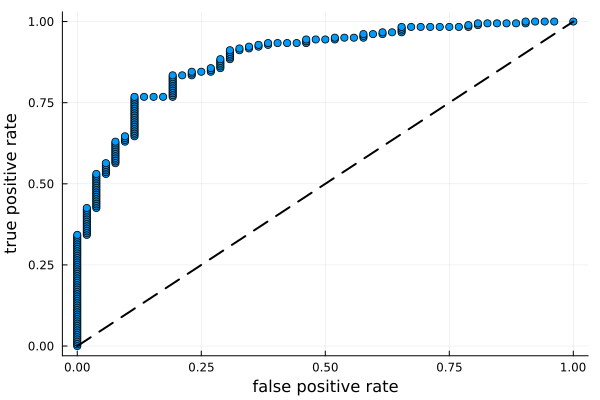

In [220]:
BayesianQDA = @load BayesianQDA pkg=ScikitLearn
_machine = get_machine(BayesianQDA(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_11 = get_measurements("BayesianQDA", ŷ, y[validation])
show(stdout, "text/plain", measurements_11)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 12. DummyClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
DummyClassifier(
  strategy = "stratified", 
  constant = nothing, 
  random_state = nothing)1×3 DataFrame
 Row │ model            measure   measurement 
     │ String           String    Float64     
─────┼────────────────────────────────────────
   1 │ DummyClassifier  accuracy        0.652
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │      8      │     37      │
├─────────────┼─────────────┼─────────────┤
│      0      │     44      │     144     │
└─────────────┴─────────────┴─────────────┘


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(DummyClassifier(strategy = stratified, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


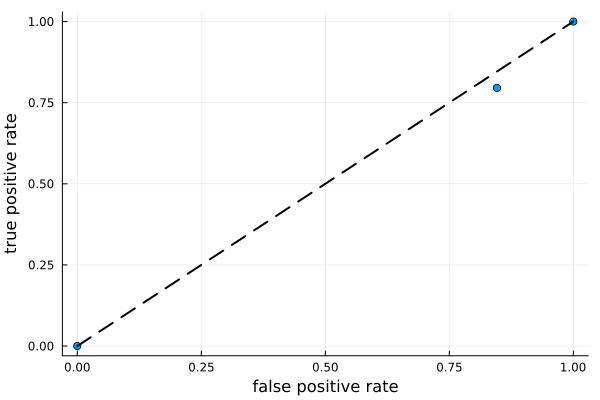

In [221]:
DummyClassifier = @load DummyClassifier pkg=ScikitLearn
_machine = get_machine(DummyClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_12 = get_measurements("DummyClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_12)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

#### 13. XGBoostClassifier, package_name=XGBoost: parameters + evaluation

import MLJXGBoostInterface ✔
XGBoostClassifier(
  num_round = 100, 
  booster = "gbtree", 
  disable_default_eval_metric = 0, 
  eta = 0.3, 
  gamma = 0.0, 
  max_depth = 6, 
  min_child_weight = 1.0, 
  max_delta_step = 0.0, 
  subsample = 1.0, 
  colsample_bytree = 1.0, 
  colsample_bylevel = 1.0, 
  lambda = 1.0, 
  alpha = 0.0, 
  tree_method = "auto", 
  sketch_eps = 0.03, 
  scale_pos_weight = 1.0, 
  updater = "auto", 
  refresh_leaf = 1, 
  process_type = "default", 
  grow_policy = "depthwise", 
  max_leaves = 0, 
  max_bin = 256, 
  predictor = "cpu_predictor", 
  sample_type = "uniform", 
  normalize_type = "tree", 
  rate_drop = 0.0, 
  one_drop = 0, 
  skip_drop = 0.0, 
  feature_selector = "cyclic", 
  top_k = 0, 
  tweedie_variance_power = 1.5, 
  objective = "automatic", 
  base_score = 0.5, 
  eval_metric = "mlogloss", 
  seed = 0, 
  nthread = 1)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159
┌ Info: Training machine(XGBoostClassifier(num_round = 100, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
[1]	train-logloss:0.49142977101368140
[2]	train-logloss:0.37738268568590422
[3]	train-logloss:0.30519482161348915
[4]	train-logloss:0.25258552632937775
[5]	train-logloss:0.21453594446566443
[6]	train-logloss:0.18508213060062453
[7]	train-logloss:0.16386254758850208
[8]	train-logloss:0.14512816768544373
[9]	train-logloss:0.12951269096130605
[10]	train-logloss:0.11922992755269587
[11]	train-logloss:0.10892801361010988
[12]	train-logloss:0.10207597802617822
[13]	train-logloss:0.09683254961281136
[14]	train-logloss:0.08833574273831059
[15]	train-logloss:0.08061556643797822
[16]	train-logloss:0.07499123593143996
[17]	train-logloss:0.07055860666153373
[18]	train-logloss:0.06657947498780176
[19]	train-logloss:0.0635567682115172

1×3 DataFrame
 Row │ model              measure   measurement 
     │ String             String    Float64     
─────┼──────────────────────────────────────────
   1 │ XGBoostClassifier  accuracy        0.871
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     30      │      8      │
├─────────────┼─────────────┼─────────────┤
│      0      │     22      │     173     │
└─────────────┴─────────────┴─────────────┘


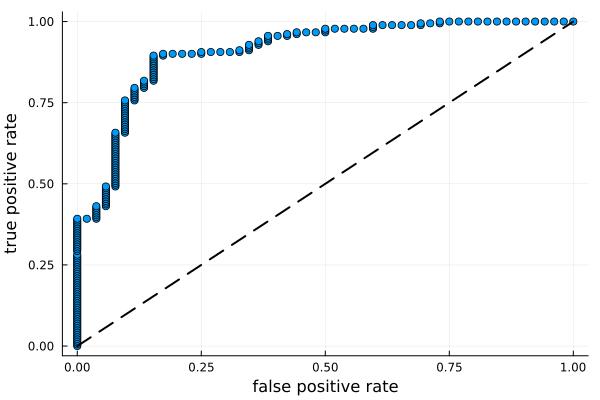

In [222]:
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost
_machine = get_machine(XGBoostClassifier(), X, y)
# evaluate: fit/predict
ŷ = fit_predict(_machine, y, train, validation)
# measurements:
measurements_13 = get_measurements("XGBoostClassifier", ŷ, y[validation])
show(stdout, "text/plain", measurements_13)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
plot_roccurve(ŷ, y[validation])

### Baseline selection

#### Measures received by algorithm

In [230]:
accuracy_df = vcat(measurements_1, measurements_2, measurements_3, measurements_4, measurements_5, measurements_6, measurements_7, measurements_8, measurements_9, measurements_10, measurements_11, measurements_12, measurements_13)
sort!(accuracy_df, [:measurement], rev=true)

,model,measure,measurement
,String,String,Float64
1,RandomForestClassifier,accuracy,0.884
2,XGBoostClassifier,accuracy,0.871
3,AdaBoostClassifier,accuracy,0.867
4,BaggingClassifier,accuracy,0.863
5,DecisionTreeClassifier,accuracy,0.863
6,GaussianNBClassifier,accuracy,0.845
7,LogisticClassifier,accuracy,0.845
8,BayesianQDA,accuracy,0.845
9,BayesianLDA,accuracy,0.824


#### Baseline selected

In [231]:
accuracy_df[1, :]

,model,measure,measurement
,String,String,Float64
1,RandomForestClassifier,accuracy,0.884
